In [1]:
import pandas as pd
import numpy as np

from keras.models import model_from_json

import progressbar
import os

import joblib
import shap

from keras.preprocessing import image
from skimage.segmentation import slic
import matplotlib.pylab as pl

#Lendo Imagens
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score

In [2]:
folder_all_shap_values = 'all_shape_values/'

In [3]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def specificity_m(y_true, y_pred):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

def balanced_acc(y_true, y_pred):
    ba = (recall(y_true, y_pred) + specificity_m(y_true, y_pred)) * 0.5  
    
    return ba

#Define the name for balanced_accuracy in the fit
balanced_acc.__name__ = 'ba'

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
data = np.load('multi_chanel_imagens.npy')

In [6]:
all_games = pd.read_csv('all_games_other_games.csv')
#Geting the target values
y = all_games[all_games['interval_frame_size'] >= 500].target

#Selecting only BPI with 500 or more frames (15 seg)
partidas = pd.DataFrame(all_games[all_games['interval_frame_size'] >= 500].partida)

#Reseting the index of dataframe (to follow the original data)
partidas.reset_index(inplace=True)
partidas.drop(['index'],axis=1, inplace=True)

path_original = "C:"

In [7]:
game_folds = pd.read_csv(f'{path_original}games_fold_ad.csv',index_col=[0])

In [8]:
games_list_test = []#Lista com o nome das partidas de cada fold
for fold in range(game_folds.columns.size - 1):
    games_names_test = game_folds[(game_folds['turn_'+str(fold)] == 15)].partida.values 
    #Pegando todas as partidas para treinamento
                                                                                    
    games_list_test.append(games_names_test)
    
idx_folds_test = [] #Lista do idx de cada fold do grid search
for fold_idx in range(len(games_list_test)):
    idx_folds_test.append(partidas[partidas.apply(lambda x: x.partida in games_list_test[fold_idx],
                                                          axis=1)].index.values)
    
#Dados de Treino

#Separa os nome de todas as partidas que NAO serão teste nas rodadas
games_list = []#Lista com o nome das partidas de cada fold
for fold in range(game_folds.columns.size - 1):
    games_names = game_folds[(game_folds['turn_'+str(fold)] != 15)].partida.values #Pegando todas as partidas para treinamento
                                                                                    
    games_list.append(games_names)
    
idx_folds = [] #Lista do idx de cada fold do grid search
for fold_idx in range(len(games_list)):
    idx_folds.append(partidas[partidas.apply(lambda x: x.partida in games_list[fold_idx], axis=1)].index.values)  

In [9]:
def get_data(fold):
    '''
    Get the data for training and test for multi channel images (11x167x16)
    '''
    #Selecting the training data
    y_train = y.iloc[idx_folds[fold]].values
    y_train_d = keras.utils.to_categorical(y_train, num_classes = 2)
    X_train = data[idx_folds[fold]]

    #Seting the test index od the fold
    X_test = data[idx_folds_test[fold]]
    y_test = y.iloc[idx_folds_test[fold]].values
    y_test_d = keras.utils.to_categorical(y_test, num_classes = 2)
    
    print(f'Leaked data?:{np.unique([index in idx_folds_test[fold] for index in idx_folds[fold]])}')

    return X_train, y_train, y_train_d, X_test, y_test, y_test_d

In [10]:
def load_model(fold):
    
    path_to_load = f'modelos_reviewed/CNN_03/{fold}/CNN_EfficientB0'

    model = keras.models.load_model(path_to_load, custom_objects={'ba':balanced_acc})
        
    return model

In [11]:
def get_shap_of_channels(sample_idx, Xplot, shap_values):
    """
    Recive the index of the sample, the image nomralized values and shap values for the image
    and compute the product of shap in to image for each channel, to find the ponderate value
    considering the value of the metric togheter shap values.
    """
    list_shap_sum = []
    for channel_idx in range(16):
        
        image_channel_values = Xplot[sample_idx, :, :, channel_idx]
        shap_channel_values = shap_values.values[sample_idx,:,:,channel_idx,0]
        
#         list_shap_sum.append(np.absolute(image_channel_values * shap_channel_values).sum())
        list_shap_sum.append(np.sum(image_channel_values * shap_channel_values))
        
    return list_shap_sum

In [12]:
def get_shap_values(actual_positive_samples, toplot):
    
    #Define the mask that will be applied in the samples
    masker_blur_3x3 = shap.maskers.Image("blur(3, 3)", actual_positive_samples[0].shape)
    
    # By default the Partition explainer is used for all  partition explainer
    explainer = shap.Explainer(f, masker_blur_3x3, output_names=class_names)
    
    #Evalue the shap model
    shap_values = explainer(actual_positive_samples, max_evals=500,
                            batch_size=1, outputs=shap.Explanation.argsort.flip[:1])
    
    return shap_values

In [13]:
# #Class names
class_names = ['fail','success']

### Calculing the Shap values

In [14]:
# def generate_all_shap_values():
def f(X):
    """
    Recive the data and apply the predict function
    """
#         tmp = X.copy()
    return model.predict(X)

for fold in range(10):
    print(f'Fold: {fold}')

    #Load the trained model (CNN with multi channel image)
    model = load_model(fold)

    #Define the data (training and test idx)
    X_train, y_train, y_train_d, X_test, y_test, y_test_d = get_data(fold)

    #Define the mask for apply in the image
    masker_blur_3x3 = shap.maskers.Image("blur(3, 3)", X_train[0].shape)

    #Defining the exapliner (model that will be analises
    #the mask that applied and name of classes)
    explainer = shap.Explainer(model.predict, masker_blur_3x3, output_names=class_names)

    #Get the positive samples of training test in actual fold to get their shap values
    df_games_actual_fold = all_games.iloc[idx_folds[fold]]
    indx = df_games_actual_fold[df_games_actual_fold['target'] == 1].index
    actual_positive_samples = data[indx]

    #Dataframe with the shap values (collumns) of each channel (row)
    df_channel_shap_values = pd.DataFrame()

    #Range for interate in the samples
    toplot = range(0, actual_positive_samples.shape[0])

    #Normalize the pixels values of the images
    Xplot = np.array([(actual_positive_samples[t] - np.min(actual_positive_samples[t]))
                      /np.ptp(actual_positive_samples[t]) for t in toplot])

    #Evalue the shap model
    shap_values = explainer(actual_positive_samples, max_evals=500,
                            batch_size=1, outputs=shap.Explanation.argsort.flip[:1])

    #Create the Dataframe with all shap values of the channels
    for i, sample in enumerate(actual_positive_samples):
        df_channel_shap_values[i] = get_shap_of_channels(i, Xplot, shap_values)

    os.makedirs(folder_all_shap_values, exist_ok=True)

    df_channel_shap_values.to_csv(f'{folder_all_shap_values}shap_values_{fold}_v2.csv', header=False)

Fold: 0


Leaked data?:[ True]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  25%|█████████████████▊                                                     | 1/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  75%|███████████████████████████████████████████████▎               | 3/4 [00:33<00:06,  6.59s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:46<00:00,  9.21s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [01:02, 15.73s/it]                                                                            


Fold: 1


Leaked data?:[ True]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  25%|█████████████████▊                                                     | 1/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  75%|███████████████████████████████████████████████▎               | 3/4 [00:27<00:06,  6.45s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:42<00:00, 10.02s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [00:55, 13.89s/it]                                                                            


Fold: 2


Leaked data?:[ True]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  25%|█████████████████▊                                                     | 1/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  75%|███████████████████████████████████████████████▎               | 3/4 [00:34<00:09,  9.54s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 11.81s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [01:04, 16.07s/it]                                                                            


Fold: 3


Leaked data?:[ True]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  25%|█████████████████▊                                                     | 1/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  75%|███████████████████████████████████████████████▎               | 3/4 [00:28<00:06,  6.53s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:42<00:00,  9.59s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [00:55, 13.87s/it]                                                                            


Fold: 4


Leaked data?:[ True]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  25%|█████████████████▊                                                     | 1/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  75%|███████████████████████████████████████████████▎               | 3/4 [00:31<00:06,  6.80s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:45<00:00,  9.82s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [00:59, 14.92s/it]                                                                            


Fold: 5


Leaked data?:[ True]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  25%|█████████████████▊                                                     | 1/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  75%|███████████████████████████████████████████████▎               | 3/4 [00:30<00:07,  7.01s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:43<00:00,  9.78s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [00:57, 14.39s/it]                                                                            


Fold: 6


Leaked data?:[ True]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  25%|█████████████████▊                                                     | 1/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  75%|███████████████████████████████████████████████▎               | 3/4 [00:38<00:07,  7.62s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 11.65s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [01:11, 17.99s/it]                                                                            


Fold: 7


Leaked data?:[ True]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  25%|█████████████████▊                                                     | 1/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  75%|███████████████████████████████████████████████▎               | 3/4 [00:30<00:07,  7.35s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:45<00:00, 10.60s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [01:00, 15.00s/it]                                                                            


Fold: 8


Leaked data?:[ True]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  25%|█████████████████▊                                                     | 1/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  75%|███████████████████████████████████████████████▎               | 3/4 [00:34<00:08,  8.76s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:48<00:00, 11.27s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [01:04, 16.07s/it]                                                                            


Fold: 9


Leaked data?:[ True]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  25%|█████████████████▊                                                     | 1/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  75%|███████████████████████████████████████████████▎               | 3/4 [00:34<00:07,  7.30s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:50<00:00, 10.64s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [01:05, 16.48s/it]                                                                            


In [15]:
fold = 9

### Ploting values 

In [16]:
df_channel_shap_values = pd.read_csv(f'{folder_all_shap_values}shap_values_{fold}_v2.csv', header=None, index_col=False)
df_channel_shap_values.drop([0],axis=1,inplace=True)

In [17]:
#Import utils.py (file with functions common for many notebooks)
import utils
metrics = utils.metrics(complet=False)
metrics = ['betcen_t1', 'betcen_t2',
           'clusteringcoeffi_t1', 'clusteringcoeffi_t2',
           'eccentricity_t1', 'eccentricity_t2',
           'entropy_t1', 'entropy_t2',
           'globalefficiency_t1', 'globalefficiency_t2',
           'locefficiency_t1', 'locefficiency_t2',
           'pagerank_t1', 'pagerank_t2',
           'vulnerability_t1', 'vulnerability_t2']

In [18]:
metrics_pt = ['centralidade_t1', 'centralidade_t2',
           'clusterização_t1', 'clusterização_t2',
           'excentricidade_t1', 'excentricidade_t2',
           'entropia_t1', 'entropia_t2',
           'eficiência global_t1', 'eficiência global_t2',
           'eficiência local_t1', 'eficiência local_t2',
           'pagerank_t1', 'pagerank_t2',
           'vulnerabilidade_t1', 'vulnerabilidade_t2']

In [19]:
#Create dict with translated metric name
dict_metrics_pt = {}
for i,metric in enumerate(metrics):
    dict_metrics_pt[metric] = metrics_pt[i]

In [20]:
#Generate the list of name of each metric (following the ordem of channels in the image
list_metric_names = []

if len(metrics) < 16:
    for metric in metrics:
        counter = 1
        while counter <=2:
            list_metric_names.append(f'{metric}_t{counter}')
            counter+=1
else:
    list_metric_names = metrics

In [21]:
df_channel_shap_values.head()

,1,2,3,4
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [23]:
#Creating the dataframe with data that will be ploted
df_shap_to_plot = pd.DataFrame(df_channel_shap_values.apply(lambda x: np.absolute(x).sum(),axis=1))
df_shap_to_plot['metric'] = list_metric_names

In [24]:
#Total values for team 1 (with ball)
df_metrics_t1 = df_shap_to_plot.apply(lambda x: x if x['metric'].split('_')[-1] == 't1' else None, axis=1).dropna()

In [25]:
#Total values for team 2 (without ball)

list_df2_indx = []
for iten in df_shap_to_plot.index:
    if df_shap_to_plot.loc[iten]['metric'].split('_')[-1] != 't1':
        list_df2_indx.append(iten)
        
df_metrics_t2 = df_shap_to_plot.loc[list_df2_indx]

In [26]:
#The total of shap value of all channel of all positive training samples
total_shap_value_t1 = df_metrics_t1.sum()
total_shap_value_t2 = df_metrics_t2.sum()

In [27]:
#Defining the % of shap than each metric represents and seting the name of metric in the df
df_metrics_t1['percentage'] = df_metrics_t1.apply(lambda x: x[0] / total_shap_value_t1[0], axis=1)
df_metrics_t2['percentage'] = df_metrics_t2.apply(lambda x: x[0] / total_shap_value_t2[0], axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [28]:
#Sorting the dataframe to improve the image ploting
df_metrics_t1.sort_values(by='percentage', ascending=True, inplace=True)
df_metrics_t2.sort_values(by='percentage', ascending=True, inplace=True)

In [29]:
df_metrics_t1['plot_metric'] = df_metrics_t1['metric'].apply(lambda x: x.split('_')[0])
df_metrics_t2['plot_metric'] = df_metrics_t2['metric'].apply(lambda x: x.split('_')[0])

In [30]:
def define_x_ticks(df_metrics):
    
    x_ticks = np.arange(0, round(max(df_metrics['percentage'].values * 100) +1), 2)
    x_ticks_labels = []
    for tick in x_ticks:
        x_ticks_labels.append(f'{tick}%')
        
    return x_ticks, x_ticks_labels

In [ ]:
x_ticks_t1, x_ticks_labels_t1 = define_x_ticks(df_metrics_t1)

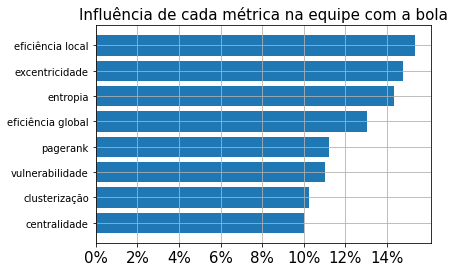

In [44]:
ax = pl.subplot()
ax.barh([dict_metrics_pt[metric].split('_')[0] for metric in df_metrics_t1['metric']],
        df_metrics_t1['percentage'].values * 100)
ax.set_xticks(x_ticks_t1)
ax.set_xticklabels(x_ticks_labels_t1,fontsize=15)
pl.title('Influência de cada métrica na equipe com a bola', fontsize=15)
ax.grid(True)

folder_save_shap_image = 'shap_values_image/'
os.makedirs(folder_save_shap_image, exist_ok=True)
# pl.savefig(f'{folder_save_shap_image}accumulated_shap_values_t1_pt.eps', bbox_inches='tight', format='eps')

In [45]:
x_ticks_t2, x_ticks_labels_t2 = define_x_ticks(df_metrics_t2)

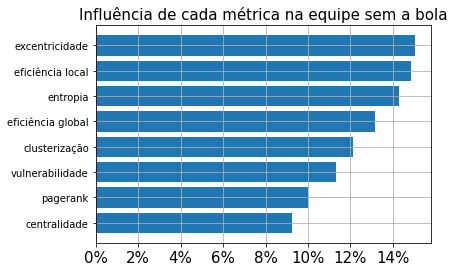

In [48]:
ax = pl.subplot()
ax.barh([dict_metrics_pt[metric].split('_')[0] for metric in df_metrics_t2['metric']],
        df_metrics_t2['percentage'].values * 100)
ax.set_xticks(x_ticks_t2)
ax.set_xticklabels(x_ticks_labels_t2,fontsize=15)
# pl.title('Influence of each metric on the team without the ball', fontsize=15)
pl.title('Influência de cada métrica na equipe sem a bola', fontsize=15)
ax.grid(True)
pl.savefig(f'{folder_save_shap_image}accumulated_shap_values_t2_pt.eps', bbox_inches='tight', format='eps')

### Plot a single pair shap values

In [14]:
# #Class names
class_names = ['falha','sucesso']

def f(X):
    """
    Data and apply the predict function
    """
    tmp = X.copy()
    return model.predict(tmp)

fold = 9

#Load the trained model (CNN with multi channel image)
model = load_model(fold)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 10, 166, 16)       1040      
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 166, 16)       64        
_________________________________________________________________
conv2 (Conv2D)               (None, 9, 165, 32)        2080      
_________________________________________________________________
reshape (Reshape)            (None, 32, 495, 3)        0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
hidden1 (Dense)              (None, 1280)              1639680   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0

In [16]:
#Define the data (training and test idx)
X_train, y_train, y_train_d, X_test, y_test, y_test_d = get_data(fold)

Leaked data?:[False]


In [17]:
#Define the mask that will be applied in the samples
masker_blur_1x1 = shap.maskers.Image("blur(1, 1)", X_train[0].shape)
masker_blur_3x3 = shap.maskers.Image("blur(3, 3)", X_train[0].shape)

In [18]:
# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker_blur_3x3, output_names=class_names)

In [19]:
#Get the positive samples of training test in actual fold to get their sahp values
df_games_actual_fold = all_games.iloc[idx_folds[fold]]
indx = df_games_actual_fold[df_games_actual_fold['target'] == 1].index
actual_positive_samples = data[indx]
# actual_positive_samples = X_train

In [20]:
#Dataframe with the shap values (collumns) of each channel (row)
df_channel_shap_values = pd.DataFrame()

toplot = range(0, actual_positive_samples.shape[0])

In [21]:
img_orig = data[7]

img_orig2 = data[24]

x2 = np.array([np.array(img_orig), np.array(img_orig2)])

In [22]:
#Normalize the pixels values of the images
Xplot = np.array([(actual_positive_samples[t] - np.min(actual_positive_samples[t]))
                  /np.ptp(actual_positive_samples[t]) for t in toplot])


In [23]:
#Evalue the shap model
shap_values = explainer(x2, max_evals=1000,outputs=shap.Explanation.argsort.flip[:1])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|███████████████████████████████████▌                                   | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 3it [00:22, 11.02s/it]                                                                            


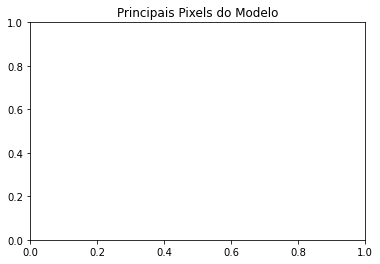

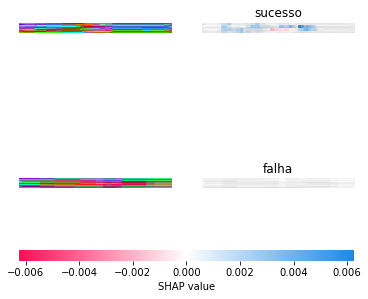

In [25]:
path = 'shap_values_image/'
os.makedirs(os.path.dirname(path), exist_ok=True)

pl.title(f"Principais Pixels do Modelo")
shap.image_plot(shap_values, show=False)
pl.savefig(f'{path}shap_values.svg', format='svg')

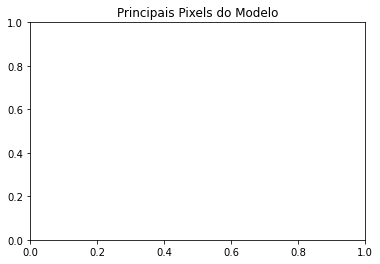

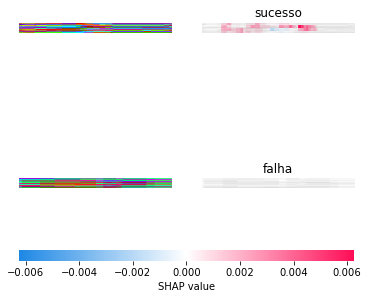

In [40]:
path = 'shap_values_image/'
os.makedirs(os.path.dirname(path), exist_ok=True)

pl.title(f"Principais Pixels do Modelo")
shap.image_plot(shap_values, show=False)
# pl.savefig(f'{path}shap_values.svg', format='svg')

In [20]:
# masker_blur_3x3 = shap.maskers.Image("blur(3, 3)", img_orig.shape)

# masker_uniform_gray  = shap.maskers.Image(np.zeros_like(img_orig) + 128, img_orig.shape)